# 머신러닝 3장 mnist

In [3]:
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

print(mnist["data"])   # mnist.data으로 접근 가능
print(mnist["target"]) # mnist.target으로 접근 가능
# mnist dataset은 Pandas DataFrame 자료구조로 되어 있음
# Pandas 자료구조에서는  DataFrame의 열을 이루는 각 Series는 각 열이름으로 된 
# dictionary style의 indexing을 통해 접근할 수 있음. 
# 또한 문자열인 열(column)이름을 이용해 속성 style(DataFrame_name.column_name) 
# 로 접근 가능

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[5 0 4 ... 4 5 6]


In [4]:
#--------------------------------------------
#  dataset 구조이해
#--------------------------------------------
X, y = mnist['data'], mnist['target']
print('X.shape={}'.format(X.shape))
print('y.shape={}'.format(y.shape))

X.shape=(70000, 784)
y.shape=(70000,)


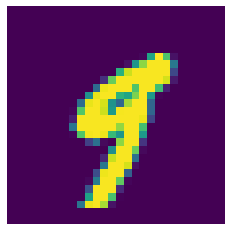

X[36000]=9




In [5]:
#--------------------------------------------
#  dataset 확인
#--------------------------------------------
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

#plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
#           interpolation='nearest')
plt.imshow(some_digit_image)
plt.axis('off')
plt.show()
#print(some_digit_image)
print("X[36000]={}\n\n".format(y[36000]))

## 3.2 이진 분류기 훈련.

In [6]:
#--------------------------------------------
# Training Binary Classifier
# 5 를 판단하는 Classifier
#--------------------------------------------
# Data Shuffling
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print('X_train=\n{}\n'.format(X_train))
print('y_train=\n{}'.format(y_train))
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

y_train_5 = (y_train == 5)  # 5는 True이고 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

print('y_train_5.shape: {}'.format(y_train_5.shape))
print(y_train_5[0:100])

X_train=
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y_train=
[5 0 4 ... 5 6 8]
y_train_5.shape: (60000,)
[False False False  True False False False False  True False False  True
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False  True False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False  True False False False False  True False False False False False
  True False False False]


In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=500, random_state=40)
sgd_clf.fit(X_train, y_train_5)

predict_value = sgd_clf.predict([some_digit])
#print('predict_value[some_digit] =\n{} '.format(some_digit, predict_value))
print('\n predict_value[some_digit] = {}'.format(predict_value))


 predict_value[some_digit] = [False]


## 성능검증

In [8]:
#--------------------------------------------
# Cross Validation
#--------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print('\nn_correct/len(y_pred) = {:0.3f}\n\n'.format(n_correct/len(y_pred)))


n_correct/len(y_pred) = 0.965



n_correct/len(y_pred) = 0.964



n_correct/len(y_pred) = 0.969




In [9]:
from sklearn.model_selection import cross_val_score
cvs5 = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
print('\n\ncross_val_score(5)={}\n\n'.format(cvs5))



cross_val_score(5)=[0.96515 0.9637  0.969  ]




In [10]:
#--------------------------------------------------------
# Dummy Classifier: Never 5
# p129
#--------------------------------------------------------
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cvs_n_5 = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
print('cross_val_score(Never 5)={}\n\n'.format(cvs_n_5))

cross_val_score(Never 5)=[0.91295 0.9069  0.9091 ]




In [11]:
#--------------------------------------------------------
# 오차행렬
# page=129
#--------------------------------------------------------
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_train_5, y_train_pred)
print('confusion matrix(5)=\n{}\n\n'.format(conf_mat))

#conf_mat_perf = confusion_matrix(y_train_5, y_train_perfect_predictions)
#print('confusion matrix(Perfect)=\n{}\n\n'.format(conf_mat_perf))

confusion matrix(5)=
[[53524  1055]
 [  988  4433]]


